In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
import tensorflow as tf
from tensorflow import keras, config

In [ ]:
from keras.layers import Dense,Input,Flatten, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam, Adamax
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array
from keras.layers import Rescaling
from keras.models import Model, load_model
from keras import Sequential , regularizers
from keras.applications import VGG19
from keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import pickle
from numpy import unique, argmax
import random
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
import os
from os import listdir, path
import seaborn as sns
import time
from sklearn.preprocessing import LabelBinarizer
import shutil
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

#resize all images to this
IMAGE_SIZE = [224,224]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview Of the Data

In [ ]:
import imghdr 
import os
import PIL
from PIL import Image

def extract_info():
  basalt=r"/content/drive/MyDrive/Dataset/Igneous/Basalt"
  granite=r"/content/drive/MyDrive/Dataset/Igneous/Granite"
  marble=r"//content/drive/MyDrive/Dataset/Metamorphic/Marble"
  quartzite=r"/content/drive/MyDrive/Dataset/Metamorphic/Quartzite"
  coal=r"/content/drive/MyDrive/Dataset/Sedimentary/Coal"
  limestone=r"/content/drive/MyDrive/Dataset/Sedimentary/Limestone"
  sandstone=r"/content/drive/MyDrive/Dataset/Sedimentary/Sandstone"
  dirlist=[basalt, granite, marble, quartzite, coal, limestone, sandstone]
  classes=["Basalt","Granite", "Marble", "Quartzite", "Coal", "Limestone","Sandstone"]  

  df = dict()
  types = list()
  widths = list()
  heights = list()
  paths = list()
  labels = list()

  for d,c in zip (dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)

        img = Image.open(fpath)
        width, height = img.size # #extract width and height from output tuple

        types.append(imghdr.what(fpath)) # Add the type of an image
        widths.append(width) # Add the width of the image
        heights.append(height) # Height of the image 
        paths.append(fpath) # Add the path of an image
        labels.append(c) # Add the label of an image
  
  df["filepaths"] = paths
  df["Type"] = types
  df["Width"] = widths
  df["Height"] = heights
  df["labels"] = labels

  return df 

  print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

In [ ]:
df = extract_info()
df = pd.DataFrame(df) # Convert To DataFrame
df.head()

filepaths  Type  Width  Height  \
0  /content/drive/MyDrive/Dataset/Igneous/Basalt/...  jpeg    380     285   
1  /content/drive/MyDrive/Dataset/Igneous/Basalt/...  jpeg    480     360   
2  /content/drive/MyDrive/Dataset/Igneous/Basalt/...  jpeg   3072    2048   
3  /content/drive/MyDrive/Dataset/Igneous/Basalt/...  jpeg   1300     981   
4  /content/drive/MyDrive/Dataset/Igneous/Basalt/...  jpeg    436     422   

   labels  
0  Basalt  
1  Basalt  
2  Basalt  
3  Basalt  
4  Basalt

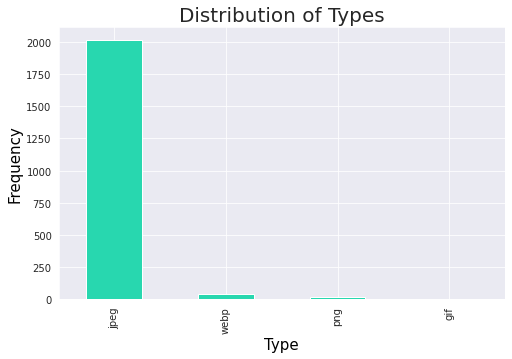



jpeg    2015
webp      37
png       17
gif        1
Name: Type, dtype: int64


In [ ]:
plt.figure(figsize = (8,5))
df["Type"].value_counts().plot.bar(color = '#28d7af')
plt.title("Distribution of Types", fontsize = 20)
plt.xlabel('Type', fontsize = 15, color = 'black')
plt.ylabel('Frequency', fontsize = 15, color = 'black')
plt.show()

print("\n")
print(df["Type"].value_counts())

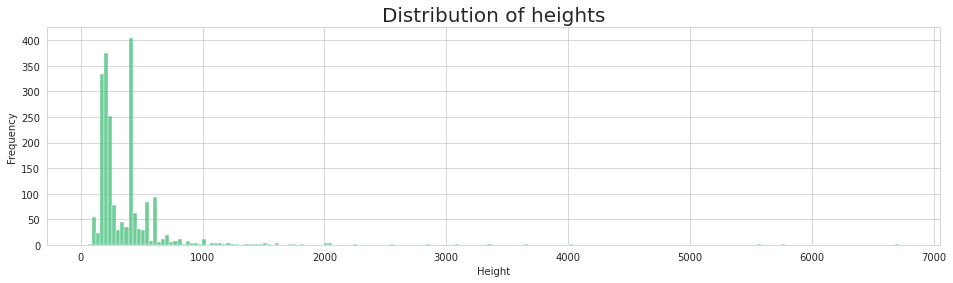

In [ ]:
plt.figure(figsize = (16,4))
sns.set_style('whitegrid')

sns.histplot(data = df, x="Height", fill = True, color = '#41be78')
plt.title('Distribution of heights', fontsize = 20)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()
print("\n")

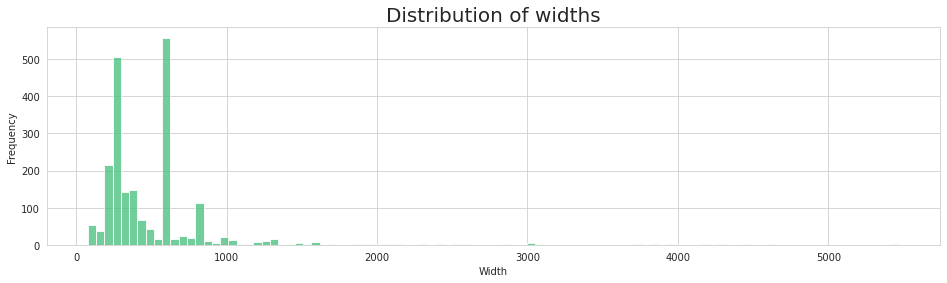

In [ ]:
plt.figure(figsize = (16,4))
sns.set_style('whitegrid')

sns.histplot(data = df, x="Width", fill = True, color = '#41be78')
plt.title('Distribution of widths', fontsize = 20)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()
print("\n")

## Image Samples

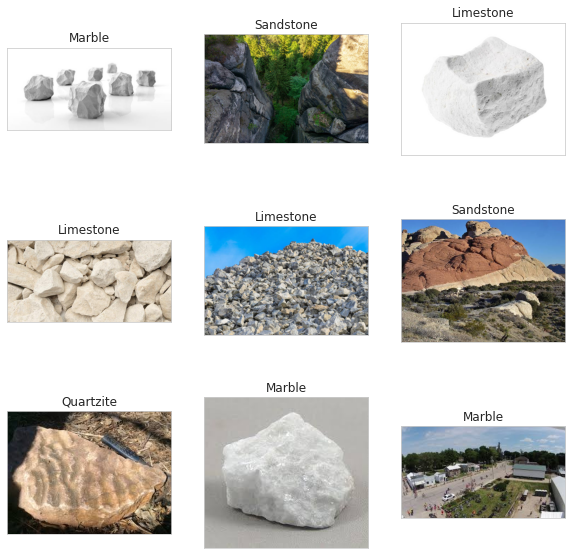

In [ ]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop over the rows and columns of the figure
for i in range(3):
    for j in range(3):
        # Get a random row from the dataframe
        row = df.sample().iloc[0]

        # Get the image path and label from the row
        img_path = row["filepaths"]
        img_label = row["labels"]

        # Read the image using OpenCV
        img = cv2.imread(img_path)

        # Convert the image from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image on the corresponding axis
        axes[i, j].imshow(img)

        # Set the title of the axis as the label
        axes[i, j].set_title(img_label)

        # Remove the ticks and labels from the axis
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# Show the figure
plt.show()

Split data to train , val and test

In [ ]:
## Split dataset into train, valid and test sets
#shape transfer to 4 dimensions (total, height,width,channel)

height=224
width=224
channels=3
batch_size=60
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)

train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)


print (len(train_df), len(test_df), len(valid_df))
vcounts=train_df['labels'].value_counts()
print (vcounts)
#vmin=np.min(list(vcounts))
#print(vmin)

1666 208 209
Quartzite    386
Marble       306
Coal         295
Limestone    268
Sandstone    264
Granite       81
Basalt        66
Name: labels, dtype: int64


In [ ]:
## Generate train, test, valid
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
    
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      
      validation_split=0.2,
      
      fill_mode='nearest')

tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 1653 validated image filenames belonging to 7 classes.
Found 207 validated image filenames belonging to 7 classes.
Found 209 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 13 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
train_df['labels'].value_counts()

Quartzite    386
Marble       306
Coal         295
Limestone    268
Sandstone    264
Granite       81
Basalt        66
Name: labels, dtype: int64

In [ ]:
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 1653 validated image filenames belonging to 7 classes.


Built the model

In [ ]:
#Build the model
model_name='ResNetV2'
base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output

x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

x=Dropout(rate=.45, seed=123)(x)  

output=Dense(7, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

model=Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

print("Model Details are: ")
#print(model.summary())

219055592/219055592 [==============================] - 2s 0us/step
Model Details are: 


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# print colored text
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return 

In [ ]:
sns.set_style('darkgrid')
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(255,0,0)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(255,0,0)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [ ]:
#Initiale callback
epochs =30
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =8 # number of epochs to wait before stopping training if monitored value does not improve 
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

 Starting training using base model ResNetV2 training all layers 



 imbalanced data address

In [ ]:
from sklearn.utils import compute_class_weight


from sklearn.utils import class_weight
import numpy as np

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_gen.classes),
                                        y = train_gen.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 3.5779220779220777,
 1: 0.8004842615012107,
 2: 2.9153439153439153,
 3: 0.9047619047619048,
 4: 0.7793493635077794,
 5: 0.6133580705009276,
 6: 0.9013086150490731}

In [ ]:

from collections import Counter
counter = Counter(train_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [ ]:
from keras.models import Model, load_model, Sequential

history=model.fit_generator(train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
              class_weight=class_weights,validation_steps=None,  shuffle=False,  initial_epoch=0)

<ipython-input-21-db1fd1bf59c2>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /30    10.609   40.835   9.47115  50.239   0.00100  0.00100  accuracy   89.81  

 2 /30     9.492   60.375   8.14543  59.809   0.00100  0.00100  accuracy   47.58  

 3 /30     8.753   67.151   7.85013  66.029   0.00100  0.00100  accuracy   47.58  

 4 /30     7.939   73.321   7.17134  72.249   0.00100  0.00100  accuracy   48.72  

 5 /30     7.650   77.495   6.93658  73.684   0.00100  0.00100  accuracy   47.04  

 6 /30     7.224   81.670   6.84492  71.770   0.00100  0.00100  accuracy   46.72  

 7 /30     6.903   83.424   6.61980  74.163   0.00100  0.00100  accuracy   50.01  

 8 /30     6.612   85.844   6.36831  76.077   0.00100  0.00100  accuracy   46.43  

 9 /30     6.388   88.687   6.25398  75.120   0.00100  0.00100  accuracy   45.26  

10 /30     6.064   91.228   6.06999  77.512   0.00100  0.00100  val_loss   46.53  

11 /30     5.859   91.531   6.05537  71.770   0.00100  0.00100  val_loss   4

## Visualize Training Results 

In [ ]:
# To plot training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

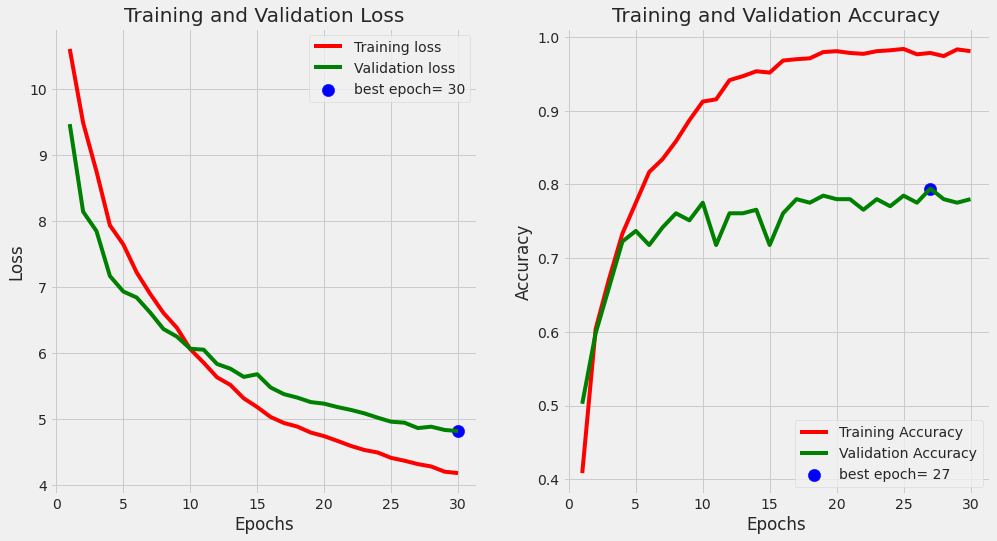

In [ ]:
tr_plot(history, 0)

## Test Accuracy

In [ ]:
# Evaluate model on test set
acc=model.evaluate(test_gen, verbose=1)[1]*100
print (' Accuracy on test set: ', acc)

4/4 [==============================] - 3s 733ms/step - loss: 5.0017 - accuracy: 0.7536
 Accuracy on test set:  75.36231875419617


## Confusion Matrix

In [ ]:
# confusion matrix
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

4/4 [==============================] - 5s 445ms/step


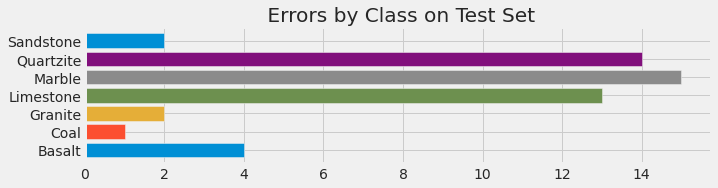

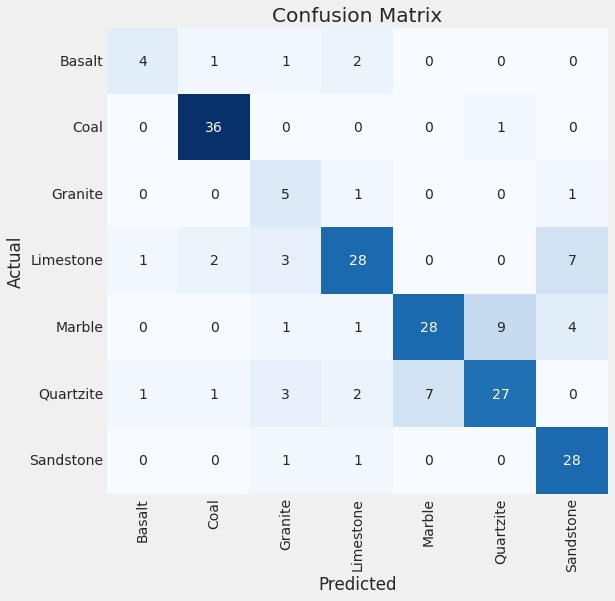

Classification Report:
----------------------
               precision    recall  f1-score   support

      Basalt       0.67      0.50      0.57         8
        Coal       0.90      0.97      0.94        37
     Granite       0.36      0.71      0.48         7
   Limestone       0.80      0.68      0.74        41
      Marble       0.80      0.65      0.72        43
   Quartzite       0.73      0.66      0.69        41
   Sandstone       0.70      0.93      0.80        30

    accuracy                           0.75       207
   macro avg       0.71      0.73      0.70       207
weighted avg       0.77      0.75      0.75       207



In [ ]:
# prediction on test set
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

In [ ]:



from keras.utils import plot_model


# visualize the model architecture
plot_model(model, to_file='model.png', show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.515237 to fit



## Save The Model 

In [ ]:
# save model
save_dir=r'./'
subject='rocks'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)